# Wine Quality Predictions
"Wine is sunlight, held together by water." - Galileo Galilei

Selecting a good wine from the liquor store can be a challenge, even for the most avid wine enthusists. Prices and labels can only get you so far. To make matters even more confusing, the year and region can have a tremendous impact on the quality too! If only there was a simpler way...

The intent for this project is to determine the optimal machine learning model for predicting the quality of the Portuguese "Vinho Verde" wine. The data used for this project was originally published by Paulo Cortez and others [1] and was provided by UCI Machine Learning on Kaggle in the form of a .csv file. It can be downloaded [here](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) [2]. Here's a quick overview of what each of the columns represents (note, descriptions are limited to what is available in the documentation):
* fixed acidity: Most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
* volatile acidity: The amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
* citric acid: Found in small quantities, citric acid can add 'freshness' and flavor to wines
* residual sugar: The amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
* chlorides: The amount of salt in the wine
* free sulfure dioxide: The free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
* total sulfure dioxide: Amount of free and bound forms of SO2; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
* density: The density of water is close to that of water depending on the percent alcohol and sugar content
* pH: Describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale 
* sulphates: A wine additive which can contribute to sulfur dioxide gas (SO2) levels, which acts as an antimicrobial and antioxidant
* alcohol: The percent alcohol content of the wine
* quality: Output variable (based on sensory data, score between 0 and 10)


To start, the libraries and tools that will be necessary for the analysis will be imported and then read in the data.

In [1]:
#Import standard libraries:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import math
import warnings
warnings.filterwarnings('ignore')

# Import Machine Learning tools and metrics:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, log_loss, matthews_corrcoef
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Import SMOTE:
from imblearn.over_sampling import SMOTE

In [2]:
# Read in data:
raw_wine = pd.read_csv('winequality-red.csv')

## Data Exploration
Now that the data has been imported, we can explore it further using the `head()` and `info()` methods as well as the `shape` attribute. The `head()` method returns a specified number of rows from the top of a DataFrame. The `info()` method returns a high level summary of a DataFrame including the number of columns, the index range, how many null values can be found in each column, and the data type (dtype) of the different columns. The shape attribute, as the name suggests, returns the dimensions of the DataFrame. Although this information is already included in the output of the `info()` method, it is easier to visualize with the output of the `shape` attribute.

In [3]:
raw_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Explore data further:
print(raw_wine.shape)
print(raw_wine.info())

(1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


From the outputs of the `head()` and `info()` methods, it is clear that the data is fairly clean; all of the features are `dtype float64` and there are no null values. 

It should be noted, however, that the scale of the features differ from one another. This can make it more difficult for parameters to be optimized while training a model, and with a limited number of epochs this could result in less accurate predictions.

To give us a better understanding of whether the features are useful for predicting the score or not, we can look at how the values of the training features relate to the quality scores. Using the `sns.barplot` function, we can quickly visualize these relationships. Visualization inspired by Vishal Kumar [3]

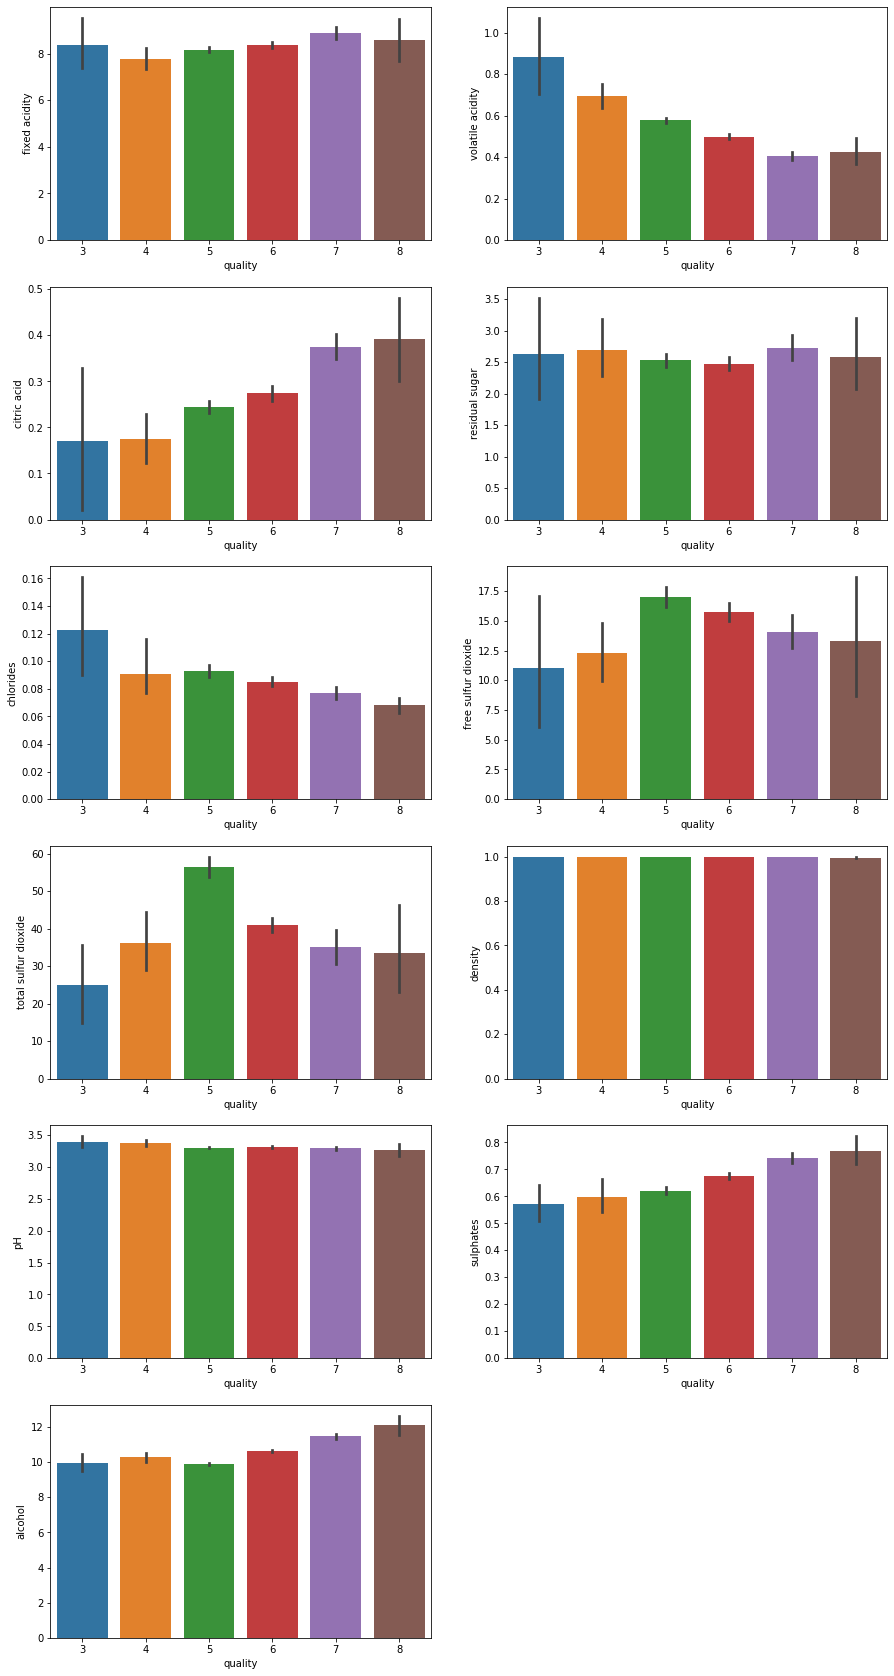

In [5]:
# Create list of model features:
raw_features = list(raw_wine.drop('quality', axis=1).columns)

# Determine number of plots:
y = math.ceil(len(raw_features) / 2)
    
# Instaciate figure object:
fig, axs = plt.subplots(y, 2, figsize=(15,30))
    
# Loop over length of list of confusion matrices:
break_counter = 0
for i in range(y):
    for j in range(2):
        break_counter += 1
        if break_counter > len(raw_features):
            axs[i,j].remove()
            break
        # Plot confusion matrix in heatmap format:
        sns.barplot(x='quality', y=raw_features[i*2 + j], data=raw_wine, ax=axs[i,j])

As is illustrated above, there are a number of columns which show clear linear trends with respect to the quality of the wine; volatile acidity, citric acid, chlorides, pH, sulphates, and alcohol. These features should fit the models well and do not need any futher processing.

Density is essentially consistent regardless of the wine quality and therefore adds no value towards training a prediction model. It will be removed from the training features to save on computation.

The remaining columns (fixed acidity, residual sugar, free sulfur dioxide, and total sulfur dioxide) appear to have a non-linear relationship with wine quality. These kinds of relationships may draw contradictions in more traditional models, so these columns will only be used to train the neural network.

It is also worth noting that the "sulfur dioxide" columns have low values in the low range of wine quality, high values in the midrange of wine qualities, and mid-range values for high quality wines. Because sulfur dioxide prevents oxidation (as was mentioned at the beginning of this notebook) the level of the substance in the wine across wine qualities may suggest that some oxidation will make the wine "better", but too much oxidation may turn the wines "bad". 

Lastly, we should take a look at the distribution of wine qualities. The plot below shows the frequency of each wine quality in the data set.

Text(0.5, 1.0, 'Distribution of Wine Quality')

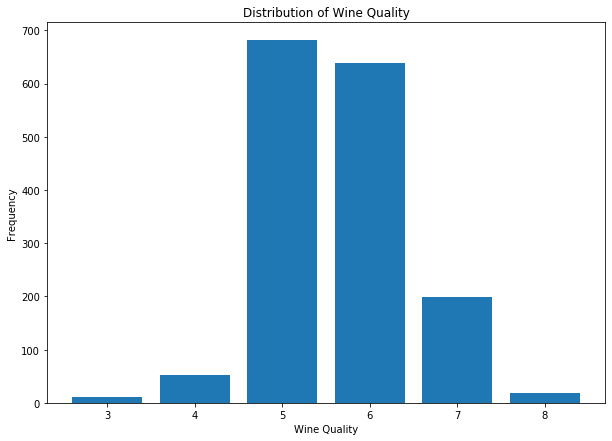

In [6]:
fig = plt.figure(figsize=(10,7))
plt.bar(raw_wine['quality'].unique(), height=raw_wine['quality'].value_counts())
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')

The bar plot above shows that the distribution of wine qualities is not balanced. In this case, the prediction models will be biased to estimate the labels that appear most frequently in the training set. In this case, that would be the scores of 5 and 6.

## Data Processing
As was mentioned in the previous section, the training features are not all on the same scale, which could lead to difficulties training the model. To prevent this from happening, each of the columns can be normalized about zero. The code below accomplishes this.

In [7]:
# Create list of feature columns
features = list(raw_wine.drop('quality', axis=1).columns)

wine = pd.DataFrame()
for feature in features:
    raw_wine[feature] = StandardScaler().fit_transform(np.array(raw_wine[feature]).reshape(-1, 1))

raw_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294,5
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364,6
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630,6
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308,5


Exploration of data above also showed that select columns should be inputed into a model, depending on what the model type is. Two list of column names are created below as described in the Data Exploration section.

In [8]:
basic_features = list(raw_wine.drop(['quality', 'density', 'fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide'], axis=1).columns)
deep_features = list(raw_wine.drop(['quality', 'density'], axis=1).columns)

As was also noted in the previous section, the distribution between scores is not balanced. The Synthetic Minority Oversampling TEchnique (SMOTE) can be used to compensate for this imbalance. Using SMOTE creates additional training examples that are simliar to existing examples that have a relatively low frequency in the training set. [4] The code below creates such a training set.

Note: Not all models will be trained with SMOTE in order to determine how effective the technique actually is in this case.

In [9]:
sm_basic = SMOTE(random_state=1)
X_train_basic, y_train_basic = sm_basic.fit_resample(raw_wine[basic_features], raw_wine['quality'])

sm_deep = SMOTE(random_state=1)
X_train_deep, y_train_deep = sm_basic.fit_resample(raw_wine[basic_features], raw_wine['quality'])

## Function Definitions
In order to streamline the process of training and evaluating multiple models, a series of functions will be defined. A description of each function's arguments, return values, and specific intended use can be found in the body of code where they are defined.

In [10]:
# [5]
def multiclass_kfold_predictions_one_v_all(inp_model, k, df, features, target, smote=False):  
    """
    Performs kfold validation on a one vs. all multiclass classification model. Returns the actual and predicted labels as two separate lists for all test folds.
    
    Arguments:
    inp_model -- sklearn model to train.
    k -- Integer, number of folds in in k-fold validation.
    df -- Pandas DataFrame containing training data and target values.
    features -- list of strings, column names in "df" that represent training data.
    target -- string, column name in "df" which represents the target values.
    smote -- True/False flag to indicate whether to create SMOTE (Synthetic Minority Oversampling TEchnique) data in the training fold.
    
    Returns: 
    true_values -- A list of the target labels for test cases in all folds.
    predictions -- A list of predicted target labels for test cases in all folds.
    """
    # Determine the unique labels of the target value:
    unique_scores = df[target].unique()
    
    # Create KFold object:
    kf = KFold(k, shuffle=True, random_state=1)
    
    #Create empty lists for true_values output and for list of label probability DataFrames:
    test_probs = []
    true_values = []
    
    # Loop over each fold in KFold object:
    for train_index, test_index in kf.split(df):
        
        # Assign training fold and determine training features and targets based on SMOTE flag:
        train = df.iloc[train_index]
        if smote == True:
            sm = SMOTE(random_state=1)
            X_train, y_train = sm.fit_resample(train[features], train[target])
        else:
            X_train = train[features]
            y_train = train[target]
        
        # Assign test fold and add target labels of test data to true_values output:
        test = df.iloc[test_index]
        true_values += list(test[target])

        # Create DataFrame to store target label probability values to:
        test_probs_df = pd.DataFrame(columns=unique_scores)
        
        # Loop over unique labels in target values:
        for i in unique_scores:
            
            # Create bool mask for the unique label to use as target values:
            values = y_train == i
            
            # Train model using training features and bool mask of target values:
            model = inp_model
            model.fit(X_train, values)
            
            # Determine probability of unique label for each training example:
            probability = model.predict_proba(test[features])[:,1]
            
            # Create column in test_probs_df for probabilites of a specific label:
            test_probs_df.loc[:,i] = probability

        # Append test_probs_df to test_probs
        test_probs.append(test_probs_df)

    # Create master list for predictions:
    predictions = []
    
    # Loop through test_probs and make predictions based on highest probability label of each test case:
    for dff in test_probs:
        predict_quality = dff.idxmax(axis=1)
        predictions += list(predict_quality)
        
    return true_values, predictions

In [11]:
# [5]
def multiclass_kfold_predictions_native(inp_model, k, df, features, target, smote=False):  
    """
    Performs kfold validation on a classification model (multiclass of binary). Returns the actual and predicted labels as two separate lists for all test folds.
    
    Arguments:
    inp_model -- sklearn model to train.
    k -- Integer, number of folds in in k-fold validation.
    df -- Pandas DataFrame containing training data and target values.
    features -- list of strings, column names in "df" that represent training data.
    target -- string, column name in "df" which represents the target values.
    smote -- True/False flag to indicate whether to create SMOTE (Synthetic Minority Oversampling TEchnique) data in the training fold.
    
    Returns: 
    true_values -- A list of the target labels for test cases in all folds.
    predictions -- A list of predicted target labels for test cases in all folds.
    """
    # Create KFold object:
    kf = KFold(k, shuffle=True, random_state=1)

    # Create empty lists for true_values and predictions outputs:
    predictions = []
    true_values = []
    
    # Loop over each fold in KFold object:
    for train_index, test_index in kf.split(df):
        
        # Assign training fold and determine training features and targets based on SMOTE flag:
        train = df.iloc[train_index]
        if smote == True:
            sm = SMOTE(random_state=1)
            X_train, y_train = sm.fit_resample(train[features], train[target])
        else:
            X_train = train[features]
            y_train = train[target]
        
        # Assign test fold and add target labels of test data to true_values output:
        test = df.iloc[test_index]
        true_value = list(test[target])
        true_values += true_value
        
        # Fit model with training data and make predictions on test data. Append predictions to predictions output:
        model = inp_model
        model.fit(X_train, y_train)
        prediction = list(model.predict(test[features]))
        predictions += prediction
        
    return true_values, predictions

In [12]:
def multiclass_kfold_predictions(models, k, df, features, target, combined=False, smote=False, oneVall=True):
    """
    Performs kfold validation on a classification model (multiclass or binary). Returns the actual and predicted labels as two separate lists for all test folds.
    
    Arguments:
    models -- list of sklearn models.
    k -- Integer, number of folds in in k-fold validation.
    df -- Pandas DataFrame containing training data and target values.
    features -- list of strings, column names in "df" that represent training data.
    target -- string, column name in "df" which represents the target values.
    combined --  True/False flag to indicates whether output should be two lists or one combined list.
    smote -- True/False flag to indicate whether to create SMOTE (Synthetic Minority Oversampling TEchnique) data in the training fold.
    oneVall -- True/False flag to indicate whether oneVall model type predictions should be included in output (important for binary classifiers).
    
    Returns: 
    native_preds -- list of output tuples from multiclass_kfold_predictions_native() function.
    oneVall_preds -- list of output tuples from multiclass_kfold_predictions_one_v_all() function.
    combined_preds -- native_preds and oneVall_preds combined. For a given model, the output tuple from multiclass_kfold_predictions_native() is followed directly by the associated output tuple from multiclass_kfold_predictions_one_v_all()
    """
    # Instanciate potential outputs as empty lists:
    native_preds = []
    oneVall_preds = []
    combined_preds = []
    
    # Loop through list of models:
    for model in models:
        
        # Assign output tuple of multiclass_kfold_predictions_native() to variable and append to relavent returned lists:
        native_pred = multiclass_kfold_predictions_native(model, k, df, features, target, smote=smote)
        native_preds.append(native_pred)
        combined_preds.append(native_pred)
        
        # Check oneVall condition:
        if oneVall == True:
            
            # Assign output tuple of multiclass_kfold_predictions_one_v_all() to variable and append to relavent returned lists:
            oneVall_pred = multiclass_kfold_predictions_one_v_all(model, k, df, features, target, smote=smote)
            oneVall_preds.append(oneVall_pred)
            combined_preds.append(oneVall_pred)
        
    # Return outputs based on argument flag conditions:
    if combined == True:
        return combined_preds
    elif oneVall == True:
        return native_preds, oneVall_preds
    else:
        return native_preds

In [13]:
def conf_matrices(val_pred_list, normalize=None):
    """
    Creates a list of confusion matrices (numpy arrays) from the list of tuples output from the multiclass_kfold_predictions() function.
    
    Arguments:
    val_pred_list -- List of tuples output from the multiclass_kfold_predictions() function. Each tuple contains a list of predictions and a list of true labels for a given model.
    normalize -- 'normalize' argument for the confusion_matrix() function.
    
    Returns: 
    conf_mats -- List of confusion matrices. Each matrix represents the the predictions of a given model.
    """
    # Create output list:
    conf_mats = []
    
    # Loop over list of model predictions and true values:
    for val_pred in val_pred_list:
        
        # Create confusion matrix:
        conf_mat = confusion_matrix(*val_pred, normalize=normalize)
        
        # Append confusion matrix to output list:
        conf_mats.append(conf_mat)
    
    return conf_mats

In [14]:
def plot_conf_matrices(conf_mats, model_names, scores, title, figsize=(15,15), fmt='5'):
    """
    Creates a series of multiclass confusion matrix plots (heatmaps) from a list of confusion matrices.
    
    Arguments:
    conf_mats -- A list of confusion matrices. Each confusion matrix corresponds to a given model.
    model_names -- A list of the models names (must be in the same order as conf_mats).
    scores -- List of labels in target variable (must match confusion matrices).
    title -- String, main title of all plots.
    figsize -- Tuple, figsize argument in plt.subplots().
    fmt -- 'fmt' argument for heatmap() function.
    """
    # Determine number of plots:
    y = int(len(model_names) / 2)
    
    # Instaciate figure object:
    fig, axs = plt.subplots(y, 2, figsize=figsize)
    fig.tight_layout(pad=4.0)
    
    # Add overall title:
    fig.suptitle(title, fontdict={'fontsize': 24}, y=1.001)
    
    # Loop over length of list of confusion matrices:
    for i in range(y):
        for j in range(2):
            
            # Plot confusion matrix in heatmap format:
            sns.heatmap(conf_mats[i*2 + j], fmt=fmt, ax=axs[i,j], annot=True, xticklabels=scores, yticklabels=scores)
            
            # Label axes of plot:
            plt.xlabel('Predicted Score')
            plt.ylabel('True Score')
            
            # Add title to heatmap plot:
            axs[i, j].set_title(model_names[i*2 + j])
            
    # Label axes of plot:
    for ax in axs.flat:
        ax.set(xlabel='Predicted Score', ylabel='True Score')

In [15]:
def plot_conf_matrices_binary(conf_mats, model_names, scores, title, figsize=(15,15), fmt='5'):
    """
    Creates a series of binary confusion matrix plots (heatmaps) from a list of confusion matrices.
    
    Arguments:
    conf_mats -- A list of confusion matrices. Each confusion matrix corresponds to a given model.
    model_names -- A list of the models names (must be in the same order as conf_mats).
    scores -- List of labels in target variable (must match confusion matrices).
    title -- String, main title of all plots.
    figsize -- Tuple, figsize argument in plt.subplots().
    fmt -- 'fmt' argument for heatmap() function.
    """
    # Determine number of plots:
    y = int(len(model_names))
    
    # Instaciate figure object:
    fig, axs = plt.subplots(y, 1, figsize=figsize)
    fig.tight_layout(pad=4.0)
    
    # Add overall title:
    fig.suptitle(title, fontdict={'fontsize': 24}, y=1.001)
    
    # Loop over length of list of confusion matrices:
    for i in range(y):
            
        # Plot confusion matrix in heatmap format:
        sns.heatmap(conf_mats[i], fmt=fmt, ax=axs[i], annot=True, xticklabels=scores, yticklabels=scores)
            
        # Add title to heatmap plot:
        axs[i].set_title(model_names[i])
    
    # Label axes of plot:
    for ax in axs.flat:
        ax.set(xlabel='Predicted Score', ylabel='True Score')

In [16]:
def class_reports(val_pred_list):
    """
    Creates a list of classification reports (dictionaries) from the list of tuples output from the multiclass_kfold_predictions() function.
    
    Arguments:
    val_pred_list -- List of tuples output from the multiclass_kfold_predictions() function. Each tuple contains a list of predictions and a list of true labels for a given model.
    
    Returns: 
    class_reps -- List of classification reports. Each report represents the the predictions of a given model.
    """
    # Create output list:
    class_reps = []
    
    # Loop over list of model predictions and true values:
    for val_pred in val_pred_list:
        
        # Create classification report:
        class_rep = classification_report(*val_pred, output_dict=True)
        
        # Append classification report to output list:
        class_reps.append(class_rep)
    
    return class_reps

In [17]:
def class_report_df_label_scores(classification_report_, labels, ignore_index=True):
    """
    Takes the precision, recall, f1-score, and support statistics from as classification report dictionary and converts it into a DataFrame.
    
    Arguments:
    classification_report_ -- Dictionary, Classification report returned from sklearn.metrics.classification_report()
    labels -- List of labels of target variable.
    ignore_index -- Flag to ignore_index in pd.Series function.
    
    Returns: 
    cr_df -- DataFrame that includes information on the precision, recall, f1-score, and support statistics for each label of a classification model.
    """
    # Create empty output DataFrame with the appropriate column titles:
    score_titles = pd.Series(['precision', 'recall', 'f1-score', 'support'])
    cr_df = pd.DataFrame(columns=score_titles)
    
    # Loop over list of labels:
    for label in labels:
        
        # Add statistics to the DataFrame for a given label:
        cr_df = cr_df.append(pd.Series(classification_report_[label], name=label), ignore_index=ignore_index)
        
    # Convert "support" column into 'int' dtype:
    cr_df['support'] = cr_df['support'].astype('int')
    
    # Capitalize titles of columns:
    cr_df.columns = cr_df.columns.str.title()
    
    return cr_df

In [18]:
def plot_class_reports(class_reps, model_names, scores, title, figsize=(15,15)):
    """
    Creates a series of classification report plots (heatmaps) from a list of classification reports.
    
    Arguments:
    class_reps -- A list of classification reports. Each classificatino report corresponds to a given model.
    model_names -- A list of the models names (must be in the same order as class_reps).
    scores -- List of labels in target variable (must match classification reports).
    title -- String, main title of all plots.
    figsize -- Tuple, figsize argument in plt.subplots().
    """
    # Determine number of plots:
    y = int(len(model_names) / 2)
    
    # Instaciate figure object:
    fig, axs = plt.subplots(y, 2, figsize=figsize)
    fig.tight_layout(pad=4.0)
    
    # Add overall title:
    fig.suptitle(title, fontdict={'fontsize': 16}, y=1.001)
    
    # Loop over length of list of classification reports:
    for i in range(y):
        for j in range(2):
            
            # Extract pertinent information from classification report and assign as a DataFrame:
            cr_df_ls = class_report_df_label_scores(class_reps[i*2 + j], scores, ignore_index=False)
            
            # Plot classification report in heatmap format:
            sns.heatmap(cr_df_ls.drop('Support', axis=1), ax=axs[i,j], annot=True, vmin=0, vmax=1)
            
            # Add title to heatmap plot:
            axs[i, j].set_title(model_names[i*2 + j])
            
    # Label axes of plot:
    for ax in axs.flat:
        ax.set(ylabel='Wine Score')

In [19]:
def class_report_df_agg_scores(classification_report_):
    """
    Takes the accuracy, precision macro avg, recall macro avg, f1-score macro avg, precision weighted avg, recall weighted avg, and f1-score weighted avg statistics from as classification report dictionary and converts it into a DataFrame.
    
    Arguments:
    classification_report_ -- Dictionary, Classification report returned from sklearn.metrics.classification_report()
    
    Returns: 
    cr_df -- DataFrame that includes information on the accuracy, precision macro avg, recall macro avg, f1-score macro avg, precision weighted avg, recall weighted avg, and f1-score weighted avg statistics for a classification model.
    """
    # Create Series for pertient labels within the layers of the input dictionary:
    score_titles = pd.Series(['precision', 'recall', 'f1-score'])
    agg_titles = pd.Series(['accuracy', 'macro avg', 'weighted avg'])
    
    # Create empty lists for 'values' and 'column names' that will form the basis of the output DataFrame.
    df_columns = []
    df_values = []
    
    # Loop through labels of first layer in dictionary:
    for at in agg_titles:
        
        # Have conditional statements as 'accuracy' is a special case:
        if at == 'accuracy':
            # Append column name and value information to the respective lists:
            df_columns.append(at)
            df_values.append(classification_report_[at])
        else:
            for st in score_titles:
                # Append column name and value information to the respective lists:
                df_columns.append(st + " " + at)
                df_values.append(classification_report_[at][st])

    # Create DataFrame from the lists of values and column names:
    cr_df = pd.DataFrame([df_values], columns=df_columns)
        
    # Capitalize titles of columns:
    cr_df.columns = cr_df.columns.str.title()
    
    return cr_df

In [20]:
def create_class_rep_agg_df(class_reps, model_names):
    """
    Takes the accuracy, precision macro avg, recall macro avg, f1-score macro avg, precision weighted avg, recall weighted avg, and f1-score weighted avg statistics from a series of classification report dictionaries and converts them into a DataFrame.
    
    Arguments:
    class_reps -- List of dictionaries, Classification reports returned from sklearn.metrics.classification_report()
    model_names -- A list of the models names (must be in the same order as class_reps).
    
    Returns: 
    cr_df -- DataFrame that includes information on the accuracy, precision macro avg, recall macro avg, f1-score macro avg, precision weighted avg, recall weighted avg, and f1-score weighted avg statistics for a series of classification models.
    """
    # Create empty DataFrame to add data to:
    class_rep_agg_df = pd.DataFrame()
    
    # Loop through classification reports:
    for report in class_reps:
        
        # Convert classification report into a DataFrame:
        cr_df_as = class_report_df_agg_scores(report)
        
        # Concatenate single report DataFrame with master DataFrame:
        class_rep_agg_df = pd.concat([class_rep_agg_df, cr_df_as])

    # Create column of models names:
    class_rep_agg_df.insert(0, "Model Names", model_names)
    
    # Reset index of master DataFrame:
    class_rep_agg_df.reset_index(inplace=True)
    class_rep_agg_df.drop('index', inplace=True, axis=1)
    
    return class_rep_agg_df

In [21]:
def create_multi_class_metric_df(val_pred_list, model_names):
    """
    Creates a DataFrame that contains performance statistics of multiclass prediction models. Statistics include Cohen's Kappa Score and Matthew's Correlation Coefficient.
    
    Arguments:
    val_pred_list -- List of tuples output from the multiclass_kfold_predictions() function. Each tuple contains a list of predictions and a list of true labels for a given model.
    model_names -- A list of the models names (must be in the same order as val_pred_list).
    
    Returns: 
    multi_class_metrics_df -- Output DataFrame as described in the description.
    """
    # Create empty DataFrame to add data to:
    df_cols = ['Model', 'Cohen\'s Kappa Score', 'Matthew\'s Correlation Coefficient']
    multi_class_metrics_df = pd.DataFrame(columns=df_cols)
    
    # Loop over number of models:
    for i in range(len(model_names)):
        
        # Prepare model perfomance data:
        model_name = model_names[i]
        ck_score = cohen_kappa_score(*val_pred_list[i])
        mcc = matthews_corrcoef(*val_pred_list[i])
        
        # Create DataFrame out of model performance data:
        row = pd.DataFrame([[model_name, ck_score, mcc]], columns=df_cols)
        
        # Concatenate single model performance DataFrame with master DataFrame:
        multi_class_metrics_df = pd.concat([multi_class_metrics_df, row])
    
    # Reset index of master DataFrame:
    multi_class_metrics_df.reset_index(inplace=True)
    multi_class_metrics_df.drop('index', inplace=True, axis=1)
    
    return multi_class_metrics_df

In [22]:
def create_binary_score_df(preds_true, model_names):
    """
    Creates a DataFrame that contains performance statistics of binary prediction models. Statistics include AUC ROC, Precision, Recall, and F1 Score.
    
    Arguments:
    preds_true -- List of tuples output from the multiclass_kfold_predictions() function. Each tuple contains a list of predictions and a list of true labels for a given model.
    model_names -- A list of the models names (must be in the same order as preds_true).
    
    Returns: 
    binary_score_df -- Output DataFrame as described in the description.
    """
    # Create empty DataFrame to add data to:
    df_cols = ["Model Name", "AUC ROC", "Precision", "Recall", "F1 Score"]
    binary_score_df = pd.DataFrame(columns=df_cols)
    
    # Loop over number of models:
    for i in range(len(model_names)):
        
        # Prepare model perfomance data:
        model_name = model_names[i]
        auc_roc = roc_auc_score(*preds_true[i])
        precision = precision_score(*preds_true[i])
        recall = recall_score(*preds_true[i])
        f1 = f1_score(*preds_true[i])
        
        # Create DataFrame out of model performance data:
        row = pd.DataFrame([[model_name, auc_roc, precision, recall, f1]], columns=df_cols)
        
        # Concatenate single model performance DataFrame with master DataFrame:
        binary_score_df = pd.concat([binary_score_df, row])
        
    # Reset index of master DataFrame:
    binary_score_df.reset_index(inplace=True)
    binary_score_df.drop('index', inplace=True, axis=1)
    
    return binary_score_df

## Model Creation and Performance Evaluation
Now that the required functions are in place, it is possible to create and evaluate many different prediction models. 

### Model Creation
The set of models will consist of all the peritations of the following options:
* Type of Model: Linear Regression, Random Forest Classifier or Neural Network
* Classifer Type: Native model output, One vs. All
* SMOTE: Without SMOTE, With SMOTE

Based on the selection of options above, a base model will be optimized for hyperparameters using the `GridSearchCV()` function. Models will then be created and predictions can be made using the functions that were made earlier in this notebook.

Because the scores of the wine are ordinal, the output of the models will be multiclass. 

### Model Evaluation
Because models have a multiclass output, a collection of metrics will be used to evaluate the model:
* Confusion matrix: The confusion matrix provides a visual indication of what labels were predicted compared to the actual label. Each column represents the predicted value and each row reprsents the true value. The percentage value of a cell in the intersection of a row and column indicates how many of the actual labels were predicted as the label of the column. Although this visualization does not directly dictate whether one model is better than another, it can provide some intuition for how well the model performed.
* Classification Reports: The classification report for a multiclass model gives three primary statistics for each label: 
    * Recall (tp / (tp + fn)) which measures how many relevent items were selected [6]
    * Precision (tp / (tp + fp)) which measures how many of the selected items are relevant [6]
    * F1-Score which is the harmonic mean of Recall and Precision [6]
   The classification report also returns aggragate level statistics including the accuacy, as well as the macro and weighted versions of the label level statistics.
* Cohen's Kappa: Cohen's kappa measures the agreement between two raters (in this case true and predicted values) who each classify N items into C mutually exclusive categories [7]. The output is normalized between 0 and 1 and, generally speaking, the closer the value is to 1, the better the classifier [8]. 
* Matthew's Correlation Coefficient: As the name somewhat suggests, is a correlation coefficient between the true and predicted labels. It is generally considered to be. A score of 1 indicates perfect prediction [8]. 

Because we are evaluating the models as a whole, Cohen's Kappa and Matthew's Correlation coefficient will be the primary metrics for evaluation.

### Set-up
To begin this process, the base models must be instaciated, and the set of hyperparameters to optimize over must be defined. The code cells below accomplish this.

In [23]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
mlp = MLPClassifier(max_iter=1000)

In [24]:
# Create hyperparameters to optimize models on:
lr_hyperparameters = {'C': np.linspace(1, 10, 10),
                     "penalty": ["l1", "l2"],
                     "solver": ["newton-cg", "lbfgs"]}

rfc_hyperparameters = {"criterion": ["gini", "entropy"],
                   "max_depth": [2,4,6,8,10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1,2,3,4,5],
                   "min_samples_split": [1,2,3,4,5],
                   "n_estimators": [100, 150, 200]
                  }

mlp_hyperparameters = {"hidden_layer_sizes": [(5,4,4), (6,4,3), (4,4,3,2)],
                       "activation": ["tanh", "relu"],
                      "solver": ["lbfgs", "adam"],
                      "alpha": np.linspace(0.0005, 0.0015, 5)}

A list of high level model names, as well as a list of unique scores will be useful when displaying and evaluating predictions.

In [25]:
model_names = ["Logistic Regression - Native", 
               "Logistic Regression - 1 vs All", 
               "Random Forest Classifier - Native", 
               "Random Forest Classifier - 1 vs All", 
               "Feed-Forward Neural Network - Native", 
               "Feed-Forward Neural Network - 1 vs All"]
scores = np.sort(raw_wine['quality'].unique()).astype('str')

### Multiclass

In [26]:
lr_grid = GridSearchCV(lr, lr_hyperparameters, cv=5, scoring=["precision_macro", "f1_macro", "recall_macro"], refit="precision_macro")
lr_grid.fit(raw_wine[basic_features], raw_wine['quality'])
lr_grid.best_params_

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [27]:
rfc_grid = GridSearchCV(rfc, rfc_hyperparameters, cv=5, scoring=["precision_macro", "f1_macro", "recall_macro"], refit="precision_macro")
rfc_grid.fit(raw_wine[basic_features], raw_wine['quality'])
rfc_grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [28]:
mlp_grid = GridSearchCV(mlp, mlp_hyperparameters, cv=5, scoring=["precision_macro", "f1_macro", "recall_macro"], refit="precision_macro")
mlp_grid.fit(raw_wine[deep_features], raw_wine['quality'])
mlp_grid.best_params_

{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (5, 4, 4),
 'solver': 'adam'}

In [29]:
lr_basic = LogisticRegression(C=10.0, penalty='l2', solver='newton-cg')

rfc_basic = RandomForestClassifier(criterion='entropy', 
                                   max_depth=10, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=4, 
                                   n_estimators=150)

mlp_basic = MLPClassifier(max_iter=1000, 
                          activation='relu', 
                          alpha=0.001, 
                          hidden_layer_sizes=(5, 4, 4), 
                          solver='adam')

In [30]:
combined_preds = multiclass_kfold_predictions([lr_basic, rfc_basic, mlp_basic],
                                              5, raw_wine, features,
                                              'quality', combined=True)

In [31]:
conf_mats = conf_matrices(combined_preds, normalize="true")
class_reps = class_reports(combined_preds)

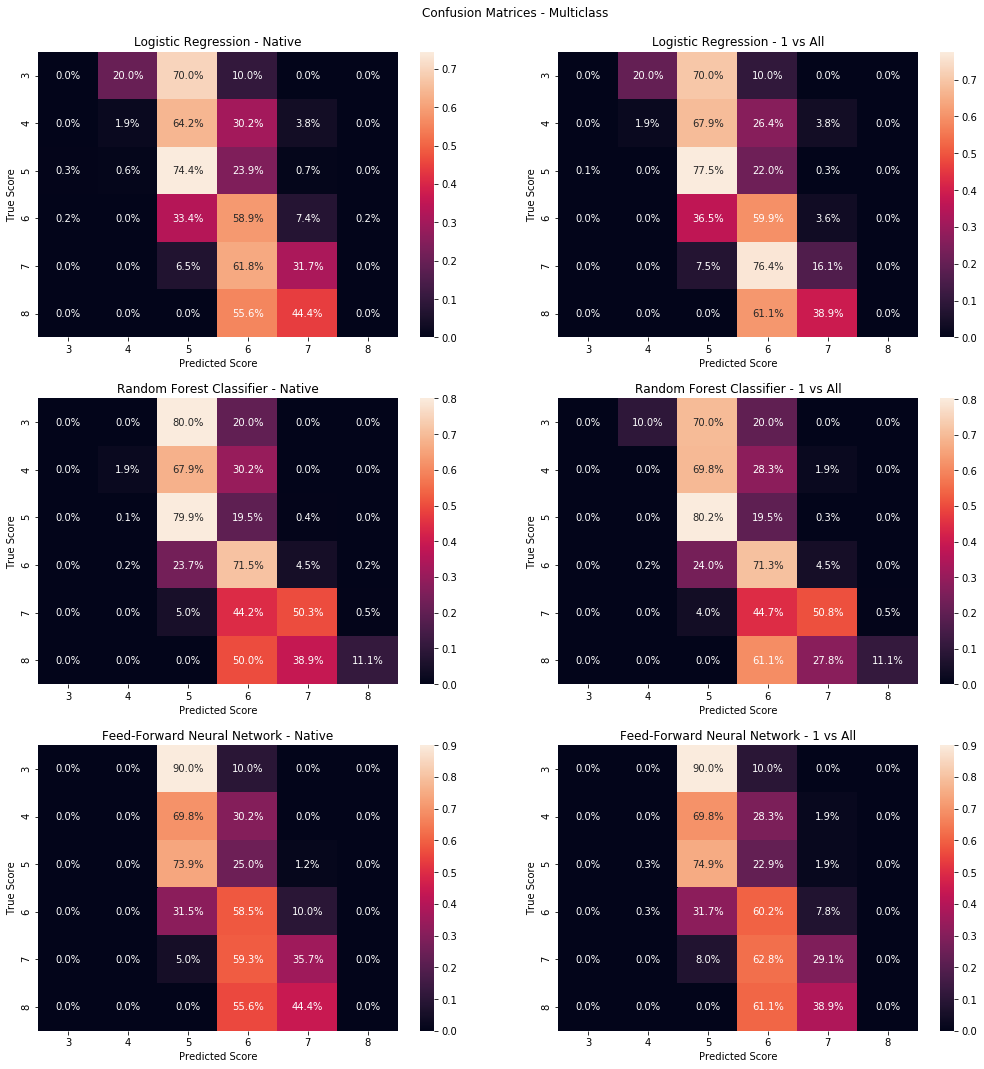

In [32]:
plot_conf_matrices(conf_mats, model_names, scores, title="Confusion Matrices - Multiclass", figsize=(15,15), fmt='.1%')

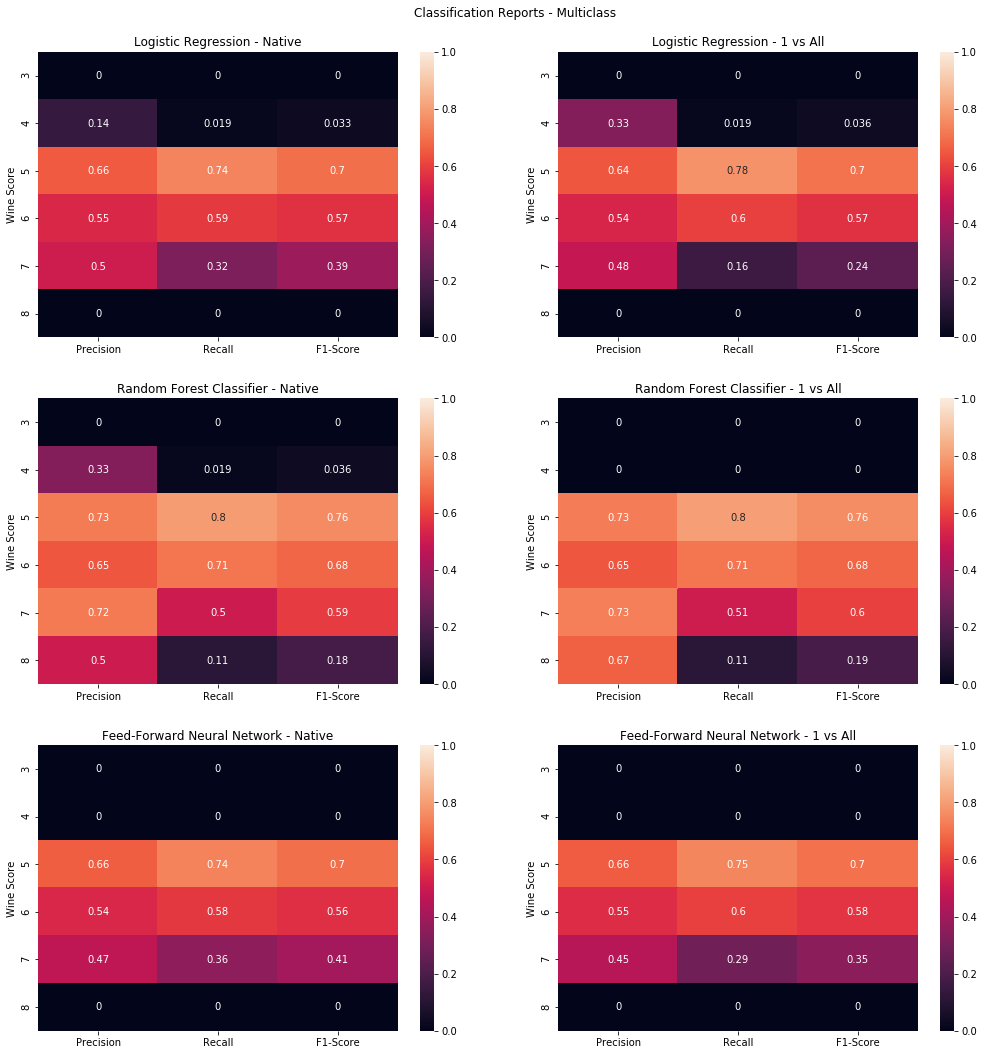

In [33]:
plot_class_reports(class_reps, model_names, scores, title="Classification Reports - Multiclass", figsize=(15,15))

In [34]:
class_rep_agg_df = create_class_rep_agg_df(class_reps, model_names)
class_rep_agg_df

,Model Names,Accuracy,Precision Macro Avg,Recall Macro Avg,F1-Score Macro Avg,Precision Weighted Avg,Recall Weighted Avg,F1-Score Weighted Avg
0,Logistic Regression - Native,0.592245,0.307936,0.278214,0.280970,0.564176,0.592245,0.572419
1,Logistic Regression - 1 vs All,0.589744,0.333483,0.258958,0.257998,0.560629,0.589744,0.557207
2,Random Forest Classifier - Native,0.689806,0.487798,0.357675,0.374945,0.673980,0.689806,0.672059
3,Random Forest Classifier - 1 vs All,0.690432,0.461829,0.355596,0.371673,0.665736,0.690432,0.671871
4,Feed-Forward Neural Network - Native,0.592245,0.279032,0.280007,0.277739,0.556708,0.592245,0.572293
5,Feed-Forward Neural Network - 1 vs All,0.595372,0.277240,0.273706,0.272022,0.557992,0.595372,0.572976


In [35]:
multi_class_metric_df = create_multi_class_metric_df(combined_preds, model_names)
multi_class_metric_df

,Model,Cohen's Kappa Score,Matthew's Correlation Coefficient
0,Logistic Regression - Native,0.333763,0.336359
1,Logistic Regression - 1 vs All,0.315659,0.321588
2,Random Forest Classifier - Native,0.494738,0.497845
3,Random Forest Classifier - 1 vs All,0.495200,0.498455
4,Feed-Forward Neural Network - Native,0.336062,0.338040
5,Feed-Forward Neural Network - 1 vs All,0.337813,0.340490


It is clear that the "Random Forest Classifier - 1 vs All" model is the best model thus far; it has the best score in every metric with the exception of recall, precision and f1 score for the quality score of 4. 

Let's see if applying SMOTE to the data during training will give us better results.

### Multiclass with SMOTE

In [36]:
lr_grid_SMOTE = GridSearchCV(lr, lr_hyperparameters, cv=5, scoring=["precision_macro", "f1_macro", "recall_macro"], refit="precision_macro")
lr_grid_SMOTE.fit(X_train_basic, y_train_basic)
lr_grid_SMOTE.best_params_

{'C': 3.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [37]:
rfc_grid_SMOTE = GridSearchCV(rfc, rfc_hyperparameters, cv=5, scoring=["precision_macro", "f1_macro", "recall_macro"], refit="precision_macro")
rfc_grid_SMOTE.fit(X_train_basic, y_train_basic)
rfc_grid_SMOTE.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [38]:
mlp_grid_SMOTE = GridSearchCV(mlp, mlp_hyperparameters, cv=5, scoring=["precision_macro", "f1_macro", "recall_macro"], refit="precision_macro")
mlp_grid_SMOTE.fit(X_train_deep, y_train_deep)
mlp_grid_SMOTE.best_params_

{'activation': 'tanh',
 'alpha': 0.0005,
 'hidden_layer_sizes': (6, 4, 3),
 'solver': 'lbfgs'}

In [39]:
lr_SMOTE = LogisticRegression(C=3.0, penalty='l2', solver='newton-cg')

rfc_SMOTE = RandomForestClassifier(criterion='entropy',
                                   max_depth=10,
                                   max_features='sqrt',
                                   min_samples_leaf=1,
                                   min_samples_split=5,
                                   n_estimators=150)

mlp_SMOTE = MLPClassifier(max_iter=1000, 
                          activation='tanh',
                          alpha=0.00125,
                          hidden_layer_sizes=(6, 4, 3),
                          solver='lbfgs')

In [40]:
combined_preds_SMOTE = multiclass_kfold_predictions([lr_SMOTE, rfc_SMOTE, mlp_SMOTE],
                                              5, raw_wine, features,
                                              'quality', combined=True)

In [41]:
conf_mats_SMOTE = conf_matrices(combined_preds_SMOTE, normalize="true")
class_reps_SMOTE = class_reports(combined_preds_SMOTE)

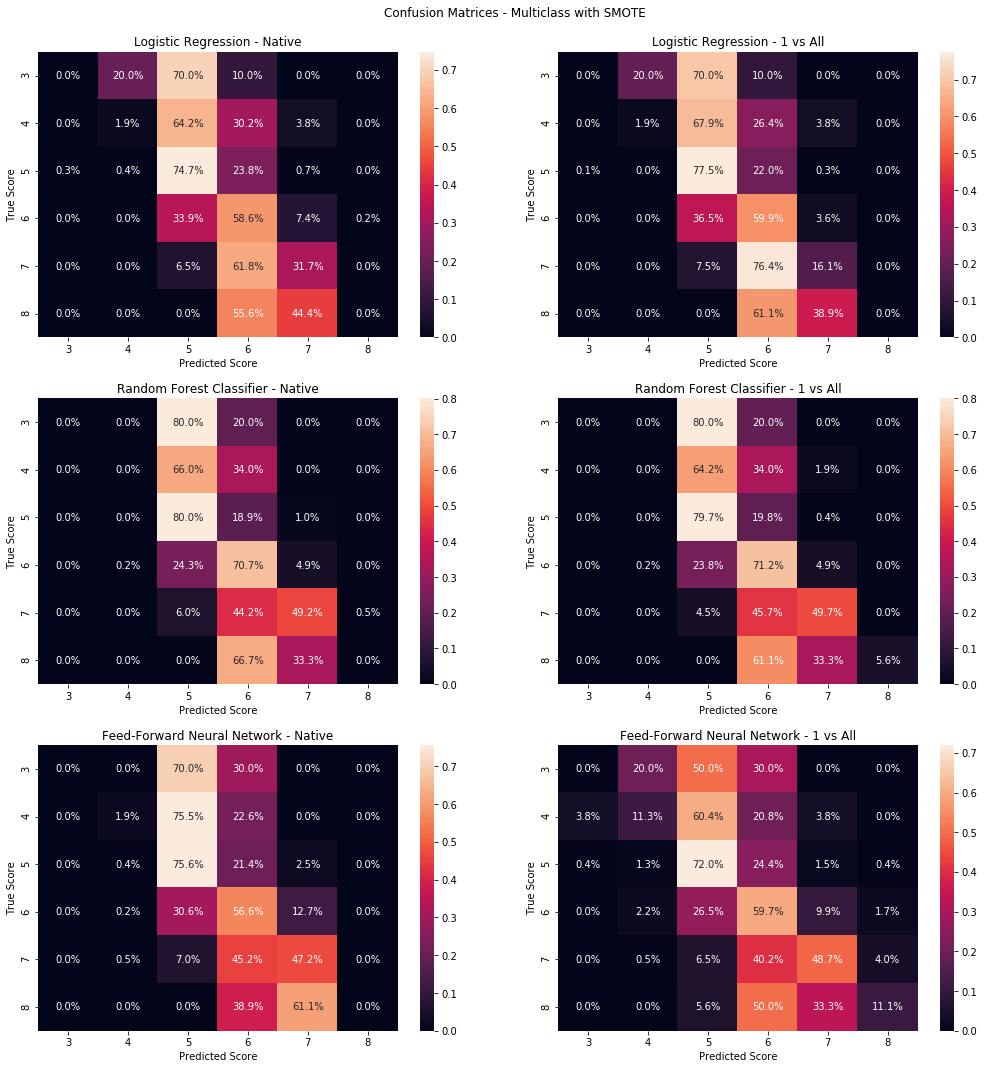

In [42]:
plot_conf_matrices(conf_mats_SMOTE, model_names, scores, title="Confusion Matrices - Multiclass with SMOTE", figsize=(15,15), fmt='.1%')

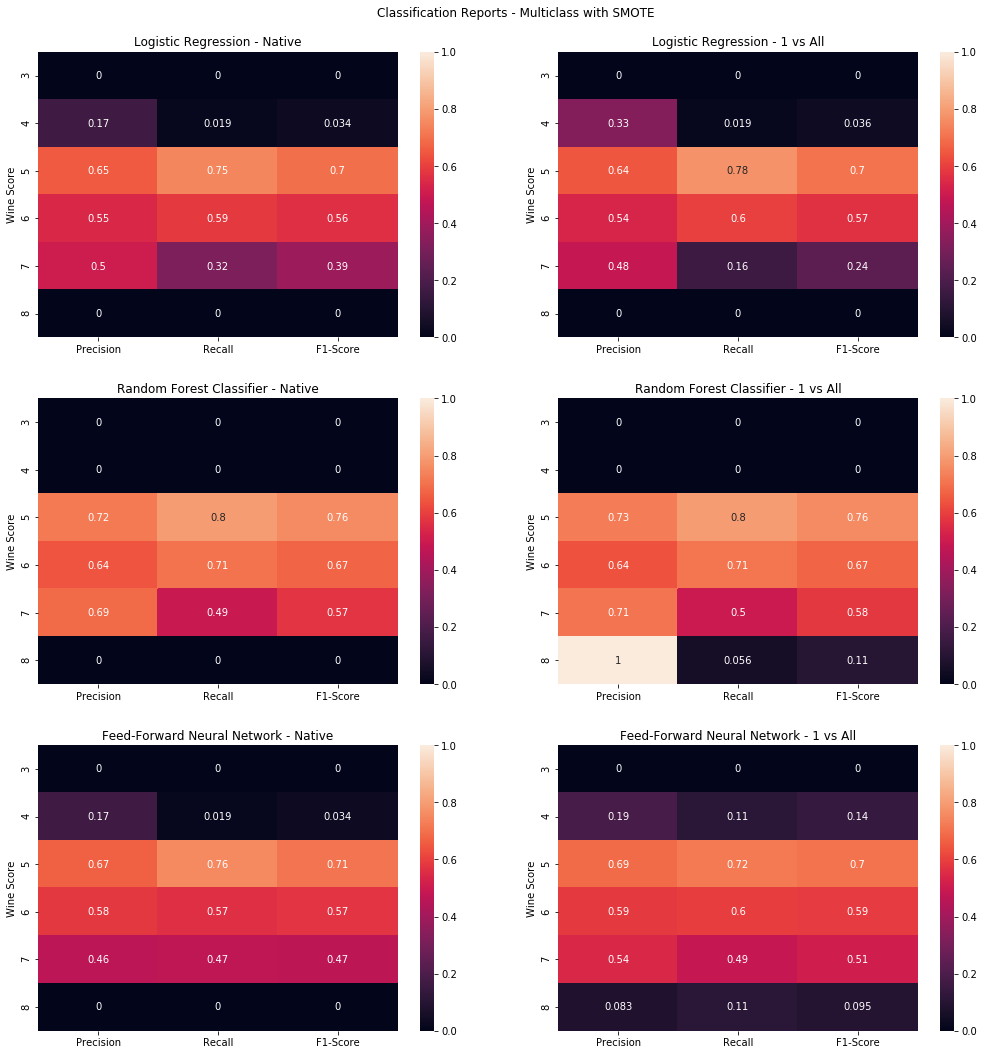

In [43]:
plot_class_reports(class_reps_SMOTE, model_names, scores, title="Classification Reports - Multiclass with SMOTE", figsize=(15,15))

In [44]:
class_rep_agg_df_SMOTE = create_class_rep_agg_df(class_reps_SMOTE, model_names)
class_rep_agg_df_SMOTE

,Model Names,Accuracy,Precision Macro Avg,Recall Macro Avg,F1-Score Macro Avg,Precision Weighted Avg,Recall Weighted Avg,F1-Score Weighted Avg
0,Logistic Regression - Native,0.592245,0.311543,0.278181,0.280834,0.564057,0.592245,0.571895
1,Logistic Regression - 1 vs All,0.589744,0.333483,0.258958,0.257998,0.560629,0.589744,0.557207
2,Random Forest Classifier - Native,0.684178,0.342713,0.333275,0.334662,0.650391,0.684178,0.663789
3,Random Forest Classifier - 1 vs All,0.686054,0.512260,0.343666,0.353910,0.664037,0.686054,0.666556
4,Feed-Forward Neural Network - Native,0.607255,0.313481,0.302217,0.297552,0.580328,0.607255,0.590617
5,Feed-Forward Neural Network - 1 vs All,0.610381,0.348679,0.338077,0.341191,0.602773,0.610381,0.605900


In [45]:
multi_class_metric_df_SMOTE = create_multi_class_metric_df(combined_preds_SMOTE, model_names)
multi_class_metric_df_SMOTE

,Model,Cohen's Kappa Score,Matthew's Correlation Coefficient
0,Logistic Regression - Native,0.333155,0.335854
1,Logistic Regression - 1 vs All,0.315659,0.321588
2,Random Forest Classifier - Native,0.484923,0.488053
3,Random Forest Classifier - 1 vs All,0.487822,0.491059
4,Feed-Forward Neural Network - Native,0.370864,0.372363
5,Feed-Forward Neural Network - 1 vs All,0.385452,0.385721


Even after applying SMOTE to the training data, the "Random Forest Classifier - 1 vs All" without SMOTE remains the best model.

It is not immediately clear why applying SMOTE to the data did not improve performance. A future improvement for this notebook would be an investigation as to why this is, and to possibly reconfigure the functions / data to achieve the desired results of SMOTE.

## Binary Models
Most of the models explored so far do not do a great job at actually identifying wines that should be purchased (scores 7-8) and those that should be avoided (3-4). To overcome this shortcoming we can look at how models will label wine qualities in a binary classifier. This way, the threshold of probability will be less ambiguous.

Note: The "Random Forest Classifier - 1 vs All" without SMOTE model did have a precision score of 1.0 for a wine score of 8, which would make it ideal for selecting the "best" wines.

### Model Creation
The models creation process will be the same as it was before with the following exceptions:
* There is no longer any need for a Classifier Type (i.e. Native model output and One vs. All) option in the model permutations
* Two types of binary classifiers will be considered; Good (scores of 7 and 8) vs Not Good (scores of 3-6), and Bad (scores of 3 and 4) vs Not Bad (scores of 5-8).

### Model Evaluation
The following metrics will be used to evaluate the binary models:
* Confusion matrix: Same as confusion matrices above.
* AUC ROC: The area under the curve of the receiver operating characteristic curve. 1 represents perfect predictions and 0 represents no correct predictions. [9]
* Recall (tp / (tp + fn)) which measures how many relevent items were selected [6]
* Precision (tp / (tp + fp)) which measures how many of the selected items are relevent [6]
* F1-Score which is the harmonic mean of Recall and Precision [6]

The primary metric to evaluate the "Good" wine predictor will be Precision - if we identify a wine as good, we want to be certain it's good. F1 score and AUC ROC will then be considered respectively.

The primary metric to evaluate the "Bad" wine predictor will be Recall - we want to avoid as many bad wines as possible. F1 score and AUC ROC will then be considered respectively.

Because we are evaluating wines as "Good" and "Bad", we will need to make some new columns in our DataFrame that represent these these classifications based on the definitions above. We will also need to create new SMOTE data for hyperparameter optimization as a result.

In [46]:
raw_wine['Good Wine'] = pd.cut(raw_wine['quality'],bins=[2,6,8],labels=[0,1])
raw_wine['Good Wine'].value_counts()

0    1382
1     217
Name: Good Wine, dtype: int64

In [47]:
raw_wine['Bad Wine'] = pd.cut(raw_wine['quality'],bins=[2,4,8],labels=[1,0])
raw_wine['Bad Wine'].value_counts()

0    1536
1      63
Name: Bad Wine, dtype: int64

In [48]:
sm_g = SMOTE(random_state=1)
X_train_g, y_train_g = sm_g.fit_resample(raw_wine[basic_features], raw_wine['Good Wine'])

sm_b = SMOTE(random_state=1)
X_train_b, y_train_b = sm_b.fit_resample(raw_wine[basic_features], raw_wine['Bad Wine'])

sm_gd = SMOTE(random_state=1)
X_train_gd, y_train_gd = sm_gd.fit_resample(raw_wine[deep_features], raw_wine['Good Wine'])

sm_bd = SMOTE(random_state=1)
X_train_bd, y_train_bd = sm_bd.fit_resample(raw_wine[deep_features], raw_wine['Bad Wine'])

### Binary (Good / Not Good)

In [49]:
lr_grid_g = GridSearchCV(lr, lr_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="precision")
lr_grid_g.fit(raw_wine[basic_features], raw_wine['Good Wine'])
lr_grid_g.best_params_

{'C': 2.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [50]:
rfc_grid_g = GridSearchCV(rfc, rfc_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="precision")
rfc_grid_g.fit(raw_wine[basic_features], raw_wine['Good Wine'])
rfc_grid_g.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

In [51]:
mlp_grid_g = GridSearchCV(mlp, mlp_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="precision")
mlp_grid_g.fit(raw_wine[deep_features], raw_wine['Good Wine'])
mlp_grid_g.best_params_

{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (5, 4, 4),
 'solver': 'adam'}

In [52]:
lr_good = LogisticRegression(C=2.0, penalty='l2', solver='newton-cg')

rfc_good = RandomForestClassifier(criterion='entropy', 
                                  max_depth=4, 
                                  max_features='log2', 
                                  min_samples_leaf=4, 
                                  min_samples_split=2, 
                                  n_estimators=100)

mlp_good = MLPClassifier(max_iter=1000, 
                         activation='tanh', 
                         alpha=0.00075, 
                         hidden_layer_sizes=(6, 4, 3), 
                         solver='adam')

In [53]:
preds_true_good = multiclass_kfold_predictions([lr_good, rfc_good, mlp_good],
                                              5, raw_wine, features,
                                              'Good Wine', combined=True, 
                                              oneVall=False)

In [54]:
conf_mats_good = conf_matrices(preds_true_good, normalize="true")
class_reps_good = class_reports(preds_true_good)

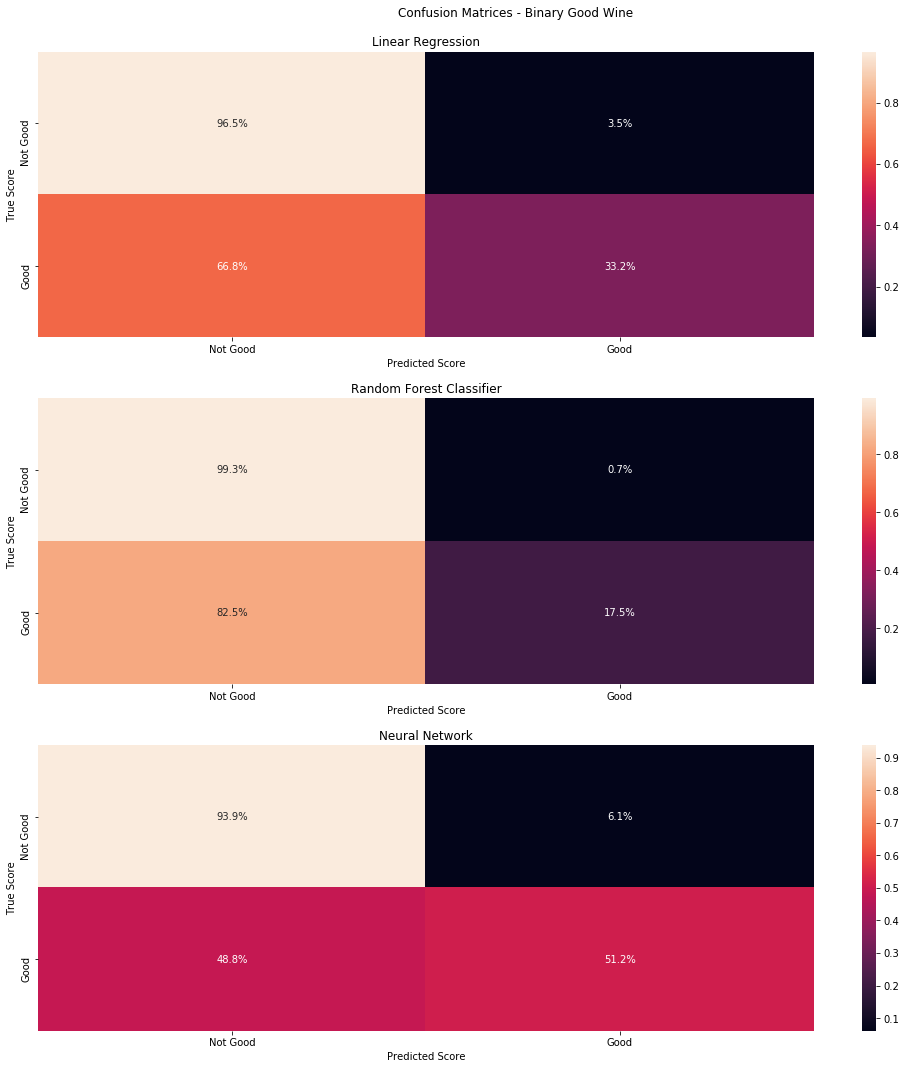

In [55]:
model_names_b = ['Linear Regression', 'Random Forest Classifier', 'Neural Network']
scores_b = ['Not Good', 'Good']

plot_conf_matrices_binary(conf_mats_good, model_names_b, scores_b, title="Confusion Matrices - Binary Good Wine", figsize=(15,15), fmt='.1%')

In [56]:
binary_score_df_good = create_binary_score_df(preds_true_good, model_names_b)
binary_score_df_good

,Model Name,AUC ROC,Precision,Recall,F1 Score
0,Linear Regression,0.648532,0.600000,0.331797,0.427300
1,Random Forest Classifier,0.584301,0.808511,0.175115,0.287879
2,Neural Network,0.725370,0.569231,0.511521,0.538835


### Binary (Good / Not Good) with SMOTE

In [57]:
lr_grid_g_SMOTE = GridSearchCV(lr, lr_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="precision")
lr_grid_g_SMOTE.fit(X_train_g, y_train_g)
lr_grid_g_SMOTE.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [58]:
rfc_grid_g_SMOTE = GridSearchCV(rfc, rfc_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="precision")
rfc_grid_g_SMOTE.fit(X_train_g, y_train_g)
rfc_grid_g_SMOTE.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [59]:
mlp_grid_g_SMOTE = GridSearchCV(mlp, mlp_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="precision")
mlp_grid_g_SMOTE.fit(X_train_gd, y_train_gd)
mlp_grid_g_SMOTE.best_params_

{'activation': 'tanh',
 'alpha': 0.00125,
 'hidden_layer_sizes': (6, 4, 3),
 'solver': 'lbfgs'}

In [60]:
lr_good_SMOTE = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')

rfc_good_SMOTE = RandomForestClassifier(criterion='gini', 
                                        max_depth=10, 
                                        max_features='sqrt', 
                                        min_samples_leaf=1, 
                                        min_samples_split=2, 
                                        n_estimators=100)

mlp_good_SMOTE = MLPClassifier(max_iter=1000, 
                               activation='tanh', 
                               alpha=0.0015, 
                               hidden_layer_sizes=(6, 4, 3), 
                               solver='lbfgs')

In [61]:
preds_true_good_SMOTE = multiclass_kfold_predictions([lr_good_SMOTE, rfc_good_SMOTE, mlp_good_SMOTE],
                                              5, raw_wine, features,
                                              'Good Wine', combined=True, 
                                              oneVall=False, smote=True)

conf_mats_good_SMOTE = conf_matrices(preds_true_good_SMOTE, normalize="true")
class_reps_good_SMOTE = class_reports(preds_true_good_SMOTE)

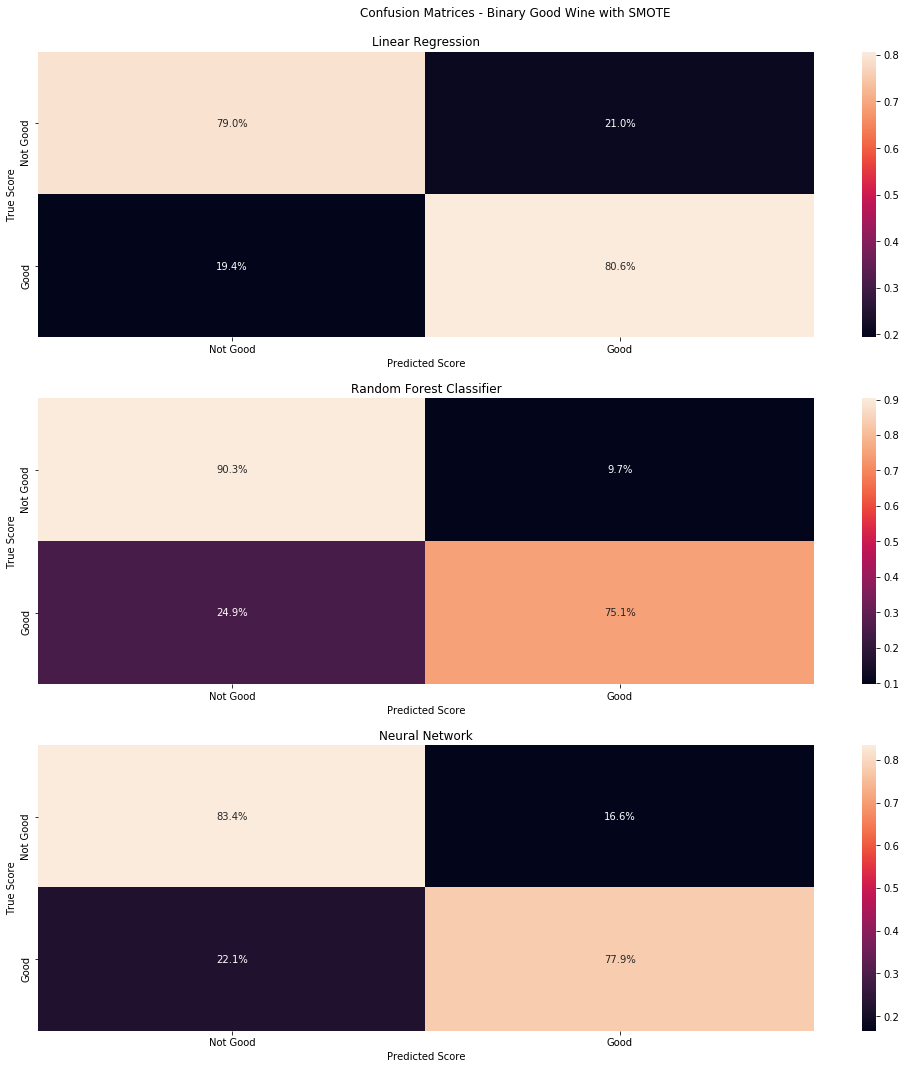

In [62]:
plot_conf_matrices_binary(conf_mats_good_SMOTE, model_names_b, scores_b, title="Confusion Matrices - Binary Good Wine with SMOTE", figsize=(15,15), fmt='.1%')

In [63]:
binary_score_df_good_SMOTE = create_binary_score_df(preds_true_good_SMOTE, model_names_b)
binary_score_df_good_SMOTE

,Model Name,AUC ROC,Precision,Recall,F1 Score
0,Linear Regression,0.798305,0.376344,0.806452,0.513196
1,Random Forest Classifier,0.827096,0.548822,0.751152,0.634241
2,Neural Network,0.806550,0.424623,0.778802,0.549593


Strangely enough, each of the model's performance metrics improved with the application of SMOTE, with the exception of precision, which ironically is the primary metric of evaluation. As such, the best binary model for selecting "Good" wines is the Random Forest Clasifier without SMOTE with a precision of 0.78.

### Binary (Bad / Not Bad)

In [64]:
lr_grid_b = GridSearchCV(lr, lr_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="recall")
lr_grid_b.fit(raw_wine[basic_features], raw_wine['Bad Wine'])
lr_grid_b.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [65]:
rfc_grid_b = GridSearchCV(rfc, rfc_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="recall")
rfc_grid_b.fit(raw_wine[basic_features], raw_wine['Bad Wine'])
rfc_grid_b.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [66]:
mlp_grid_b = GridSearchCV(mlp, mlp_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="recall")
mlp_grid_b.fit(raw_wine[deep_features], raw_wine['Bad Wine'])
mlp_grid_b.best_params_

{'activation': 'tanh',
 'alpha': 0.00125,
 'hidden_layer_sizes': (6, 4, 3),
 'solver': 'lbfgs'}

In [67]:
lr_bad = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')

rfc_bad = RandomForestClassifier(criterion='gini', 
                                 max_depth=8, 
                                 max_features='log2', 
                                 min_samples_leaf=1, 
                                 min_samples_split=2, 
                                 n_estimators=100)

mlp_bad = MLPClassifier(max_iter=1000, 
                        activation='tanh', 
                        alpha=0.00125, 
                        hidden_layer_sizes=(6, 4, 3), 
                        solver='lbfgs')

In [68]:
preds_true_bad = multiclass_kfold_predictions([lr_bad, rfc_bad, mlp_bad],
                                              5, raw_wine, features,
                                              'Bad Wine', combined=True, 
                                              oneVall=False, smote=True)

conf_mats_bad = conf_matrices(preds_true_bad, normalize="true")
class_reps_bad = class_reports(preds_true_bad)

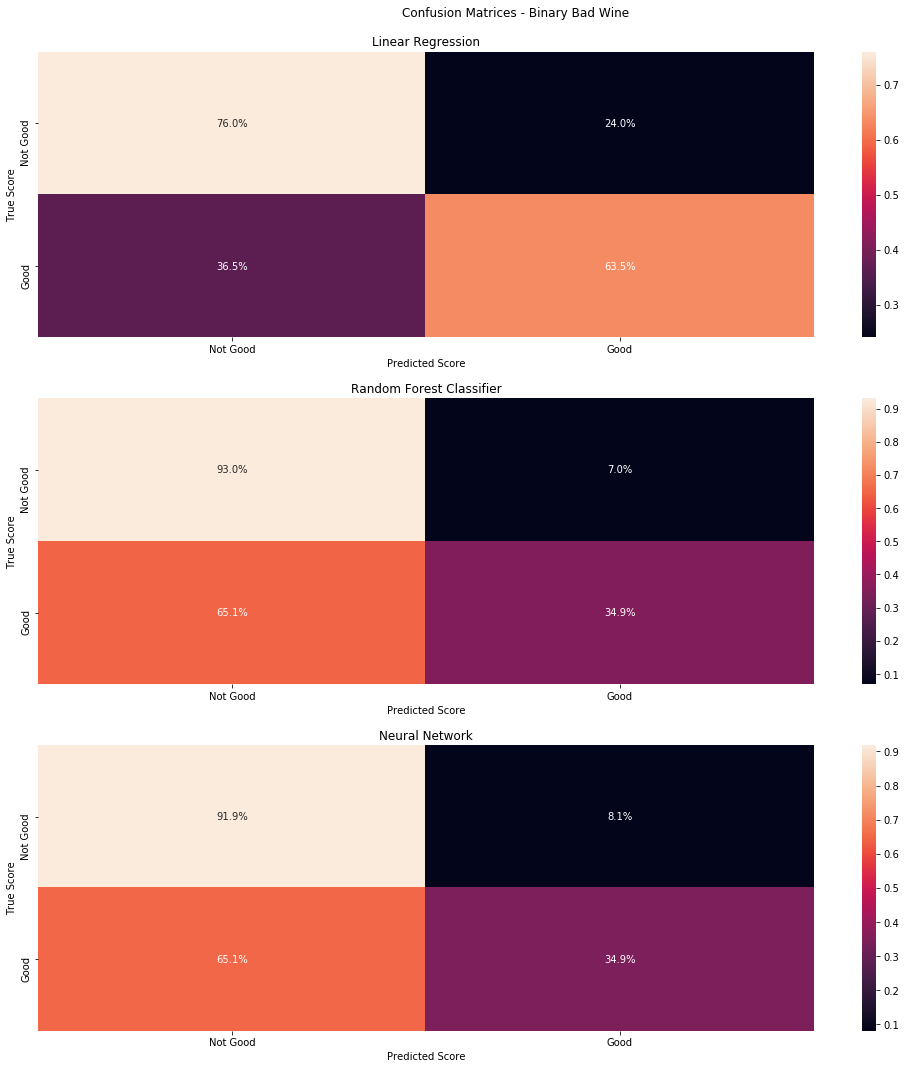

In [69]:
plot_conf_matrices_binary(conf_mats_bad, model_names_b, scores_b, title="Confusion Matrices - Binary Bad Wine", figsize=(15,15), fmt='.1%')

In [70]:
binary_score_df_bad = create_binary_score_df(preds_true_bad, model_names_b)
binary_score_df_bad

,Model Name,AUC ROC,Precision,Recall,F1 Score
0,Linear Regression,0.697343,0.097800,0.634921,0.169492
1,Random Forest Classifier,0.639772,0.170543,0.349206,0.229167
2,Neural Network,0.633913,0.149660,0.349206,0.209524


### Binary (Bad / Not Bad) with SMOTE

In [71]:
lr_grid_b_SMOTE = GridSearchCV(lr, lr_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="recall")
lr_grid_b_SMOTE.fit(X_train_b, y_train_b)
lr_grid_b_SMOTE.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [72]:
rfc_grid_b_SMOTE = GridSearchCV(rfc, rfc_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="recall")
rfc_grid_b_SMOTE.fit(X_train_b, y_train_b)
rfc_grid_b_SMOTE.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [73]:
mlp_grid_b_SMOTE = GridSearchCV(mlp, mlp_hyperparameters, cv=5, scoring=["precision", "f1", "recall"], refit="recall")
mlp_grid_b_SMOTE.fit(X_train_bd, y_train_bd)
mlp_grid_b_SMOTE.best_params_

{'activation': 'relu',
 'alpha': 0.00075,
 'hidden_layer_sizes': (6, 4, 3),
 'solver': 'lbfgs'}

In [74]:
lr_bad_SMOTE = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')

rfc_bad_SMOTE = RandomForestClassifier(criterion='gini', 
                                       max_depth=10, 
                                       max_features='sqrt', 
                                       min_samples_leaf=1, 
                                       min_samples_split=2, 
                                       n_estimators=200)

mlp_bad_SMOTE = MLPClassifier(max_iter=1000, 
                              activation='relu', 
                              alpha=0.0015, 
                              hidden_layer_sizes=(6, 4, 3), 
                              solver='lbfgs')

In [75]:
preds_true_bad_SMOTE = multiclass_kfold_predictions([lr_bad_SMOTE, rfc_bad_SMOTE, mlp_bad_SMOTE],
                                              5, raw_wine, features,
                                              'Bad Wine', combined=True, 
                                              oneVall=False, smote=True)

conf_mats_bad_SMOTE = conf_matrices(preds_true_bad_SMOTE, normalize="true")
class_reps_bad_SMOTE = class_reports(preds_true_bad_SMOTE)

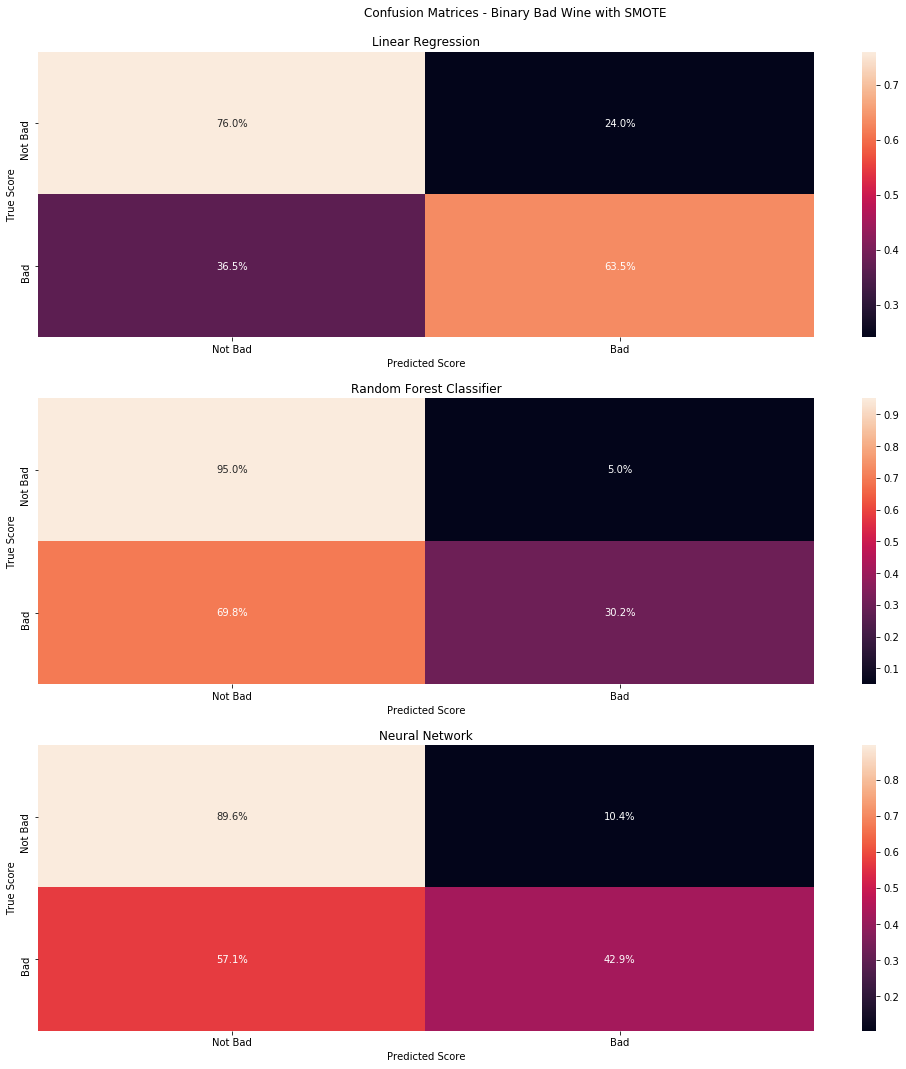

In [76]:
scores_bb = ["Not Bad", "Bad"]
plot_conf_matrices_binary(conf_mats_bad_SMOTE, model_names_b, scores_bb, title="Confusion Matrices - Binary Bad Wine with SMOTE", figsize=(15,15), fmt='.1%')

In [77]:
binary_score_df_bad_SMOTE = create_binary_score_df(preds_true_bad_SMOTE, model_names_b)
binary_score_df_bad_SMOTE

,Model Name,AUC ROC,Precision,Recall,F1 Score
0,Linear Regression,0.697343,0.097800,0.634921,0.169492
1,Random Forest Classifier,0.625729,0.197917,0.301587,0.238994
2,Neural Network,0.662202,0.144385,0.428571,0.216000


It is clear from the data above that the best model for identifying "Bad" wines is the binary Linear Regression Model (with or without SMOTE) with a recall score of 0.63.

## Conclusion
The best model of choice for predicting wine quality is of course dependent upon what your goal is. If you would like to...

... Show off to your friends how well you can identify a wine score:
    Choose the Multiclass Random Forest Classifier - 1 vs All without SMOTE model which has a Cohen's Kappa and MCC of 0.50 and 0.50 respectively.

... Find good wine:
    Choose the the Multiclass Random Forest Classifier - 1 vs All without SMOTE model which has a precisions of 0.75 and 1.0 for wine scores of 7 and 8 respectively. Note: Although the "Good" binary Random Forest Classifier achieved a precision of 0.78 for "good" wine, we are essentially gaurenteed great wine (score of 8) with the multiclass version, and a score of 0.75 is not that much worse for wines that scored 7.

... Avoid bad wine:
    Choose the "Bad" binary Linear Regression Model (with or without SMOTE) with a recall score of 0.63.
    
Although this is a good start, there's always room for improvement!

## Next Steps
There are a few things that could be done to try and improve the models:
* It would be ideal to train the models with specific loss functions. Unfortunately, to do this with the `sklearn` framework, we would need to modify the source code of the library MULTIPLE TIMES. This is far from ideal. Another framework such as `TensorFlow` might work better. 
* SMOTE data during hyperparameter optimization: The application of SMOTE when training the multiclass models did not result in an improved performance. An investigation as to why this is the case and possible reimplmentation of the technique could improve the corresponding models' performance.
* Feature engineering: Earlier in the notebook, it was mentioned that based on the levels of sulfur dioxide at different qualities of wine that some oxidation may improve the quality of the wine whereas too much oxidation may cause it to become bad. Further investigation into wine characteristics like this may lead to the development of additional features that could improve model performance.
* The probability threshold of the binary models could be modified to try to improve performance further.

## References
[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis., Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

[2] https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009/code?datasetId=4458&sortBy=voteCount

[3] V. Kumar, Prediction of quality of Wine, https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine

[4] William Vorhies, Dealing With Imbalanced Datasets, Data Science Central, 2017 Sep 5, https://www.datasciencecentral.com/profiles/blogs/dealing-with-imbalanced-datasets

[5] Jain, Ritika. (2020). Re: How can I create a single confusion matrix after K fold cross validation ?. Retrieved from: https://www.researchgate.net/post/How_can_I_create_a_single_confusion_matrix_after_K_fold_cross_validation/5f89d22d29ccb76f7031a5d3/citation/download. 

[6] Wikipedia contributors. F-score [Internet]. Wikipedia, The Free Encyclopedia; 2021 Mar 12, 16:40 UTC [cited 2021 Mar 12]. Available from: https://en.wikipedia.org/w/index.php?title=F-score&oldid=1011750044. 

[7] Wikipedia contributors. Cohen's kappa [Internet]. Wikipedia, The Free Encyclopedia; 2021 Feb 28, 17:56 UTC [cited 2021 Mar 12]. Available from: https://en.wikipedia.org/w/index.php?title=Cohen%27s_kappa&oldid=1009453725. 

[8] Harsha Goonewardana, Evaluating Multi-Class Classifiers, Medium - Apprentice Journal, 2019 Jan 3, https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

[9] Machine Learning Crash Course - Classification: ROC Curve and AUC, Google, 2020 Feb 10, https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc